In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from opf import rted2, dcopf, rted3

from ev_ssm import ev_ssm

# load data

In [2]:
print(andes.__version__)
print(pp.__version__)

1.7.0.post49.dev0+g6fad9f28
2.8.0


In [3]:
# load EV aggregator data
caseH = 10

sse = ev_ssm(ts=caseH, N=10000, step=1, tp=100,
             lr=0.1, lp=100, seed=2022, name="EVA")


sse.load_A("Aest.csv")   
# sse.A = np.zeros((60, 60))

EVA: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.


In [4]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/Test_opf_base_jwang/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual'
ssa.TDS.config.save_mode = 'manual'

# set PQ constant load
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on 'numba' to accelerate TDS.
ssa.config.numba

Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/Test_opf_base_jwang"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Loaded generated Python code in "/Users/buxinshe/.andes/pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/Test_opf_base_jwang/ieee39_ev2.xlsx"...
Input file parsed in 0.0601 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0228 seconds.


0

## Load synthetic

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

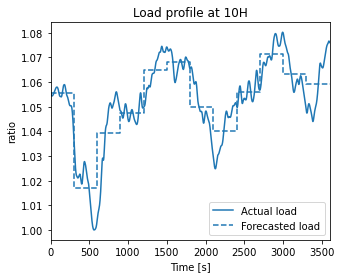

In [5]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/Test_opf_base_jwang/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 1*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min()  + 1
if caseH == 18:
    d_syn['sload'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 1

# smooth
d_syn['sload'] = d_syn['sload'].rolling(20).mean()
    
# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['sload'], color='tab:blue', linestyle='-')
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup pandapower and gurobipy attributes
ssp: pandapower attribute

ssd: rted gurobipy attribute

In [6]:
# --- set up EV generator data ---

ev_idx = 'PV_10'
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=sse.Ptc)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=sse.Pu)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=sse.Pl)

True

In [7]:
# --- convert to a pandapower instance ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0038 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221392125e-09
Converged in 5 iterations in 0.0045 seconds.
Power flow results are consistent. Conversion is successful.


True

In [8]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,183.8160,1.0,False,True,0.0,None,True,200.000000,1500.000000,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,515.7648,1.0,False,True,0.0,None,True,150.000000,900.000000,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,536.0664,1.0,False,True,0.0,None,True,100.000000,800.000000,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,657.8496,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,733.7940,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,712.5456,1.0,False,True,0.0,None,True,100.000000,800.000000,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,682.0464,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,532.1616,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,1001.7300,1.0,False,True,0.0,None,True,100.000000,1000.000000,NaN
9,PV_10,37,-36.128532,1.052803,100.0,0.000,0.0000,1.0,False,True,0.0,None,False,-38.104337,1144.862135,NaN


In [9]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
prumax = sse.g_frc()[0]
prdmax = sse.g_frc()[1]
ssd.def_type2([ev_idx], [prumax], [prdmax])

# set ramp5
ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# adjust SFR cost of EV lower than SynGen
ssd.cost.cru = 0.1
ev_loc = ssd.cost[ssd.cost.idx == ev_idx].index[0]
ssd.cost.cru.iloc[ev_loc] = 0.0999
ssd.cost.crd = ssd.cost.cru

# update p_pre from standard DCOPF results
ssd.set_p_pre()

# sovle the RTED
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0036 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221392125e-09
Converged in 5 iterations in 0.0044 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x82af07da
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xbbb6db8b
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [2e-02, 2e+03]
Presolve removed 117 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,13.425285,0.0,0.0,0.0,0.0
1,PV_2,1.500000,0.0,0.0,0.0,0.0
2,PV_3,1.000000,0.0,0.0,0.0,0.0
3,PV_4,1.000000,0.0,0.0,0.0,0.0
4,PV_5,7.000000,0.0,0.0,0.0,0.0
5,PV_6,8.000000,0.0,0.0,0.0,0.0
6,PV_7,7.000000,0.0,0.0,0.0,0.0
7,PV_8,7.000000,0.0,0.0,0.0,0.0
8,PV_9,10.000000,0.0,0.0,0.0,0.0
9,PV_10,-0.361285,0.0,0.0,0.0,0.0


In [10]:
ssd.cost

,idx,c2,c1,c0,cru,crd
0,PV_1,0,1.0,0,0.1000,0.1000
1,PV_2,0,1.0,0,0.1000,0.1000
2,PV_3,0,1.0,0,0.1000,0.1000
3,PV_4,0,1.0,0,0.1000,0.1000
4,PV_5,0,1.0,0,0.1000,0.1000
5,PV_6,0,1.0,0,0.1000,0.1000
6,PV_7,0,1.0,0,0.1000,0.1000
7,PV_8,0,1.0,0,0.1000,0.1000
8,PV_9,0,1.0,0,0.1000,0.1000
9,PV_10,0,0.1,0,0.0999,0.0999


## Benchmark pandapower and gurobipy

In [11]:
pp.rundcopp(ssp)

ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")

ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x82af07da
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.


pp cost=6038.91567888246, gb cost=60.3891567865185


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,969.031188,92.622757,16.790833,1.0,1192.528532
1,698.703250,311.488301,7.983509,1.0,900.000000
2,597.772456,149.407550,9.078709,1.0,100.000000
3,518.259385,131.140357,8.283271,1.0,100.000000
4,518.279017,146.559740,7.809376,1.0,100.000000
5,588.778207,227.749422,11.200506,1.0,800.000000
6,513.962068,63.219181,14.024880,1.0,700.000000
7,443.346412,-27.585564,12.501029,1.0,700.000000
8,744.396549,118.941642,13.586346,1.0,1000.000000
9,-36.128532,0.000000,13.586346,1.0,-36.128532


# Co-sim

## Link table between pandapower and andes

In [12]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


In [13]:
ssa_gov_idx_ctrl

['TGOV1_1',
 'TGOV1_2',
 'TGOV1_3',
 'TGOV1_4',
 'TGOV1_5',
 'TGOV1_6',
 'TGOV1_7',
 'TGOV1_8',
 'TGOV1_9',
 'TGOV1_10']

## Auxiliary function

In [14]:
# --- def. functions ---

def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """
        Get the active power (TurbineGov/DG) after TDS, a DataFrame
    """
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov ---
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')

    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg

    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))

    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')

    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')

    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ratio=100):
    """
        Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``
    """
    load = d_syn['sload'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp) * ratio
    load_u = abs(load_ci[1] - load_exp) * ratio
    return load_u, load_d, load_exp

## Co-sim parameters

In [15]:
# --- co-sim constants ---
t_total = 3600    # total simulation time

# length of each interval
intv_ed = 300   # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

# number of each interval
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Co-sim loop

In [16]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

t_total = 700

for end_time in range(t_total):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- update load ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, ratio=100)
        ssp.load.scaling = load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        # initially set previous setpoints with standard DCOPF results
        # or set `pe` from TDS
        if end_time > 0:
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                                     right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre': 'pe', 'idx': 'stg_idx'})

        # def. SFR requirements and calc. EV SFR capacities
        [prumax, prdmax] = sse.g_frc()
        # def. percentage of EV SFR capacities
        ssd.def_type2([ev_idx], [prumax*0.0], [prdmax*0.0])
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # solve RTED
        dcres = ssd.get_res() 

        # reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, modify setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis to normal limits
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- allocate AGC ---
        # --- calc. AGC ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- assign AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG;
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)
        # c.EV;
        agc_ev = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_ev['paux2'] = agc_ev.paux * agc_ev.gammap
        sse_agc = agc_ev[agc_ev.stg_idx == ev_idx].paux2.values

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                               attr='v', value=ssp_res.pref[cond_gov].values)
            # update DG setpoints;
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                       attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if end_time == 0:
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        # initial load point set as the dispatch point
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['sload'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['sload'].iloc[end_time])
        # run `sse`
        sse.run(tf=caseH+end_time/3600, Pi=sse_agc[0],
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
        sse.report(is_report=False)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[ssp_res.stg_idx == ev_idx].values[0],
                   attr='v', value=sse.Ptc)

    # run TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # update AGC PI Controller
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xdb9efcc6
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3565544e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.356554357e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xaa49beac
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [3e-01, 2e+03]
Presolve removed 96 rows and 4 columns
Presolve time: 0.00s
Presolved: 21 rows, 29 columns, 74 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4629688e+01   1.889833e+01   0.000000e+00      0s
       2    6.4078851e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.407885147e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0035 seconds.
0: |F(x)| = 7.713204511
1: |F(x)| = 3.598306139
2: |F(x)| = 0.2024434999
3: |F(x)| = 0.0008451788859
4: |F(x)| = 3.105063495e-08
Converged in 5 iterations in 0.0042 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed in 0.0348 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed 

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0008 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.0506 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 0.0530 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=16.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=17.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=18.00 sec completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=19.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=20.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=21.00 sec completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=22.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=23.00 sec completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=24.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=25.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=26.00 sec completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=27.00 sec completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=28.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=29.00 sec completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=30.00 sec completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=31.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=32.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=33.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=34.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=35.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=36.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=37.00 sec completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=38.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=39.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=40.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=41.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=42.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=43.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=44.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=45.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=46.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=47.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=48.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=49.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=50.00 sec completed in 0.0494 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=51.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=52.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=53.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=54.00 sec completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=55.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=56.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=57.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=58.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=59.00 sec completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=60.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=61.00 sec completed in 0.0449 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=62.00 sec completed in 0.0496 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=63.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=64.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=65.00 sec completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=66.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=67.00 sec completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=68.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=69.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=70.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=71.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=72.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=73.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=74.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=75.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=76.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=77.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=78.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=79.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=80.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=81.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=82.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=83.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=84.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=85.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=86.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=87.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=88.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=89.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=90.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=91.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=92.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=93.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=94.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=95.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=96.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=97.00 sec completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=98.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=99.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=100.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=101.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=102.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=103.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=104.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=105.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=106.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=107.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=108.00 sec completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=109.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=110.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=111.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=112.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=113.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=114.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=115.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=116.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=117.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=118.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=119.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=120.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=121.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=122.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=123.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=124.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=125.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=126.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=127.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=128.00 sec completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=129.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=130.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=131.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=132.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=133.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=134.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=135.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=136.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=137.00 sec completed in 0.0490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=138.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=139.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=140.00 sec completed in 0.0585 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=141.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=142.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=143.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=144.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=145.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=146.00 sec completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=147.00 sec completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=148.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=149.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=150.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=151.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=152.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=153.00 sec completed in 0.0489 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=154.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=155.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=156.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=157.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=158.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=159.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=160.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=161.00 sec completed in 0.0490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=162.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=163.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=164.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=165.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=166.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=167.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=168.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=169.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=170.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=171.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=172.00 sec completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=173.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=174.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=175.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=176.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=177.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=178.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=179.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=180.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=181.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=182.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=183.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=184.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=185.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=186.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=187.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=188.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=189.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=190.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=191.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=192.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=193.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=194.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=195.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=196.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=197.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=198.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=199.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=200.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=201.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=202.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=203.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=204.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=205.00 sec completed in 0.0499 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=206.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=207.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=208.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=209.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=210.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=211.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=212.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=213.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=214.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=215.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=216.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=217.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=218.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=219.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=220.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=221.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=222.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=223.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=224.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=225.00 sec completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=226.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=227.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=228.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=229.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=230.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=231.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=232.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=233.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=234.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=235.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=236.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=237.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=238.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=239.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=240.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=241.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=242.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=243.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=244.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=245.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=246.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=247.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=248.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=249.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=250.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=251.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=252.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=253.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=254.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=255.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=256.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=257.00 sec completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=258.00 sec completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=259.00 sec completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=260.00 sec completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=261.00 sec completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=262.00 sec completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=263.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=264.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=265.00 sec completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=266.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=267.00 sec completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=268.00 sec completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=269.00 sec completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=270.00 sec completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=271.00 sec completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=272.00 sec completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=273.00 sec completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=274.00 sec completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=275.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=276.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=277.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=278.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=279.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=280.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=281.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=282.00 sec completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=283.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=284.00 sec completed in 0.0501 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=285.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=286.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=287.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=288.00 sec completed in 0.0548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=289.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=290.00 sec completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=291.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=292.00 sec completed in 0.0567 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=293.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=294.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=295.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=296.00 sec completed in 0.0583 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=297.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=298.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=299.00 sec completed in 0.0462 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x2f743d51
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 95 rows and 4 columns
Presolve time: 0.00s
Presolved: 22 rows, 29 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2715510e+01   2.005187e+01   0.000000e+00      0s
      10    6.2715510e+01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.271551036e+01


Successfully solve RTED.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=300.00 sec completed in 0.0629 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=301.00 sec completed in 0.0636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=302.00 sec completed in 0.0618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=303.00 sec completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=304.00 sec completed in 0.0634 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=305.00 sec completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=306.00 sec completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=307.00 sec completed in 0.0615 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=308.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=309.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=310.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=311.00 sec completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=312.00 sec completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=313.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=314.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=315.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=316.00 sec completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=317.00 sec completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=318.00 sec completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=319.00 sec completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=320.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=321.00 sec completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=322.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=323.00 sec completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=324.00 sec completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=325.00 sec completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=326.00 sec completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=327.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=328.00 sec completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=329.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=330.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=331.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=332.00 sec completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=333.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=334.00 sec completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=335.00 sec completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=336.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=337.00 sec completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=338.00 sec completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=339.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=340.00 sec completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=341.00 sec completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=342.00 sec completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=343.00 sec completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=344.00 sec completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=345.00 sec completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=346.00 sec completed in 0.0821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=347.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=348.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=349.00 sec completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=350.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=351.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=352.00 sec completed in 0.0608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=353.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=354.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=355.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=356.00 sec completed in 0.0565 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=357.00 sec completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=358.00 sec completed in 0.0622 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=359.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=360.00 sec completed in 0.0608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=361.00 sec completed in 0.0617 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=362.00 sec completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=363.00 sec completed in 0.0545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=364.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=365.00 sec completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=366.00 sec completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=367.00 sec completed in 0.0554 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=368.00 sec completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=369.00 sec completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=370.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=371.00 sec completed in 0.0547 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=372.00 sec completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=373.00 sec completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=374.00 sec completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=375.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=376.00 sec completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=377.00 sec completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=378.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=379.00 sec completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=380.00 sec completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=381.00 sec completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=382.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=383.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=384.00 sec completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=385.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=386.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=387.00 sec completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=388.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=389.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=390.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=391.00 sec completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=392.00 sec completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=393.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=394.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=395.00 sec completed in 0.0876 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=396.00 sec completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=397.00 sec completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=398.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=399.00 sec completed in 0.0803 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=400.00 sec completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=401.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=402.00 sec completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=403.00 sec completed in 0.0808 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=404.00 sec completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=405.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=406.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=407.00 sec completed in 0.0814 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=408.00 sec completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=409.00 sec completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=410.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=411.00 sec completed in 0.0808 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=412.00 sec completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=413.00 sec completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=414.00 sec completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=415.00 sec completed in 0.0688 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=416.00 sec completed in 0.0812 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=417.00 sec completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=418.00 sec completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=419.00 sec completed in 0.0608 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=420.00 sec completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=421.00 sec completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=422.00 sec completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=423.00 sec completed in 0.0633 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=424.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=425.00 sec completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=426.00 sec completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=427.00 sec completed in 0.0613 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=428.00 sec completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=429.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=430.00 sec completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=431.00 sec completed in 0.0550 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=432.00 sec completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=433.00 sec completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=434.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=435.00 sec completed in 0.0546 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=436.00 sec completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=437.00 sec completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=438.00 sec completed in 0.0571 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=439.00 sec completed in 0.0541 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=440.00 sec completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=441.00 sec completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=442.00 sec completed in 0.0596 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=443.00 sec completed in 0.0504 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=444.00 sec completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=445.00 sec completed in 0.0560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=446.00 sec completed in 0.0563 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=447.00 sec completed in 0.0499 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=448.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=449.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=450.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=451.00 sec completed in 0.0457 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=452.00 sec completed in 0.0548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=453.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=454.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=455.00 sec completed in 0.0486 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=456.00 sec completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=457.00 sec completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=458.00 sec completed in 0.0535 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=459.00 sec completed in 0.0489 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=460.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=461.00 sec completed in 0.0596 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=462.00 sec completed in 0.0560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=463.00 sec completed in 0.0480 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=464.00 sec completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=465.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=466.00 sec completed in 0.0578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=467.00 sec completed in 0.0476 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=468.00 sec completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=469.00 sec completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=470.00 sec completed in 0.0584 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=471.00 sec completed in 0.0489 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=472.00 sec completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=473.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=474.00 sec completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=475.00 sec completed in 0.0477 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=476.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=477.00 sec completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=478.00 sec completed in 0.0601 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=479.00 sec completed in 0.0464 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=480.00 sec completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=481.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=482.00 sec completed in 0.0581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=483.00 sec completed in 0.0593 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=484.00 sec completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=485.00 sec completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=486.00 sec completed in 0.0547 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=487.00 sec completed in 0.0483 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=488.00 sec completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=489.00 sec completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=490.00 sec completed in 0.0578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=491.00 sec completed in 0.0481 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=492.00 sec completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=493.00 sec completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=494.00 sec completed in 0.0604 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=495.00 sec completed in 0.0503 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=496.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=497.00 sec completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=498.00 sec completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=499.00 sec completed in 0.0556 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=500.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=501.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=502.00 sec completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=503.00 sec completed in 0.0614 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=504.00 sec completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=505.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=506.00 sec completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=507.00 sec completed in 0.0643 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=508.00 sec completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=509.00 sec completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=510.00 sec completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=511.00 sec completed in 0.0640 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=512.00 sec completed in 0.0631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=513.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=514.00 sec completed in 0.0505 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=515.00 sec completed in 0.0453 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=516.00 sec completed in 0.0575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=517.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=518.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=519.00 sec completed in 0.0630 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=520.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=521.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=522.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=523.00 sec completed in 0.0477 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=524.00 sec completed in 0.0522 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=525.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=526.00 sec completed in 0.0487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=527.00 sec completed in 0.0471 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=528.00 sec completed in 0.0548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=529.00 sec completed in 0.0496 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=530.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=531.00 sec completed in 0.0470 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=532.00 sec completed in 0.0550 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=533.00 sec completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=534.00 sec completed in 0.0484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=535.00 sec completed in 0.0472 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=536.00 sec completed in 0.0570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=537.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=538.00 sec completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=539.00 sec completed in 0.0476 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=540.00 sec completed in 0.0594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=541.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=542.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=543.00 sec completed in 0.0476 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=544.00 sec completed in 0.0599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=545.00 sec completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=546.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=547.00 sec completed in 0.0489 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=548.00 sec completed in 0.0553 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=549.00 sec completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=550.00 sec completed in 0.0487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=551.00 sec completed in 0.0554 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=552.00 sec completed in 0.0565 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=553.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=554.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=555.00 sec completed in 0.0475 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=556.00 sec completed in 0.0510 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=557.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=558.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=559.00 sec completed in 0.0463 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=560.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=561.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=562.00 sec completed in 0.0487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=563.00 sec completed in 0.0472 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=564.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=565.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=566.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=567.00 sec completed in 0.0468 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=568.00 sec completed in 0.0553 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=569.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=570.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=571.00 sec completed in 0.0491 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=572.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=573.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=574.00 sec completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=575.00 sec completed in 0.0465 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=576.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=577.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=578.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=579.00 sec completed in 0.0461 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=580.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=581.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=582.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=583.00 sec completed in 0.0471 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=584.00 sec completed in 0.0568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=585.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=586.00 sec completed in 0.0520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=587.00 sec completed in 0.0476 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=588.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=589.00 sec completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=590.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=591.00 sec completed in 0.0480 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=592.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=593.00 sec completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=594.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=595.00 sec completed in 0.0469 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=596.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=597.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=598.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=599.00 sec completed in 0.0488 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x14991068
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [3e-01, 2e+03]
Presolve removed 95 rows and 4 columns
Presolve time: 0.00s
Presolved: 22 rows, 29 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4854070e+01   2.276495e+01   0.000000e+00      0s
      12    6.4854070e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.485406971e+01


Successfully solve RTED.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=600.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=601.00 sec completed in 0.0605 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=602.00 sec completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=603.00 sec completed in 0.0669 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=604.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=605.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=606.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=607.00 sec completed in 0.0671 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=608.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=609.00 sec completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=610.00 sec completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=611.00 sec completed in 0.0862 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=612.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=613.00 sec completed in 0.0552 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=614.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=615.00 sec completed in 0.0568 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=616.00 sec completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=617.00 sec completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=618.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=619.00 sec completed in 0.0611 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=620.00 sec completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=621.00 sec completed in 0.0497 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=622.00 sec completed in 0.0490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=623.00 sec completed in 0.0478 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=624.00 sec completed in 0.0622 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=625.00 sec completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=626.00 sec completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=627.00 sec completed in 0.0595 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=628.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=629.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=630.00 sec completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=631.00 sec completed in 0.0719 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=632.00 sec completed in 0.0544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=633.00 sec completed in 0.0550 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=634.00 sec completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=635.00 sec completed in 0.0488 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=636.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=637.00 sec completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=638.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=639.00 sec completed in 0.0646 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=640.00 sec completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=641.00 sec completed in 0.0567 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=642.00 sec completed in 0.0512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=643.00 sec completed in 0.0485 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=644.00 sec completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=645.00 sec completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=646.00 sec completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=647.00 sec completed in 0.0588 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=648.00 sec completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=649.00 sec completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=650.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=651.00 sec completed in 0.0646 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=652.00 sec completed in 0.0607 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=653.00 sec completed in 0.0619 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=654.00 sec completed in 0.0564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=655.00 sec completed in 0.0516 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=656.00 sec completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=657.00 sec completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=658.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=659.00 sec completed in 0.0632 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=660.00 sec completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=661.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=662.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=663.00 sec completed in 0.0662 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=664.00 sec completed in 0.0650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=665.00 sec completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=666.00 sec completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=667.00 sec completed in 0.0489 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=668.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=669.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=670.00 sec completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=671.00 sec completed in 0.0469 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=672.00 sec completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=673.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=674.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=675.00 sec completed in 0.0538 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=676.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=677.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=678.00 sec completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=679.00 sec completed in 0.0661 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=680.00 sec completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=681.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=682.00 sec completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=683.00 sec completed in 0.0456 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=684.00 sec completed in 0.0619 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=685.00 sec completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=686.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=687.00 sec completed in 0.0682 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=688.00 sec completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=689.00 sec completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=690.00 sec completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=691.00 sec completed in 0.0687 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=692.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=693.00 sec completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=694.00 sec completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=695.00 sec completed in 0.0532 seconds.
/var/folders/lp/339w9x555nn7lghf3slwfprh0000gn/T/ipykernel_11333/3230763387.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=696.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=697.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=698.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=699.00 sec completed in 0.0627 seconds.


# Exit andes and plot

In [17]:
ssa.exit_code

0

[Text(0.5, 443.06770833333275, 'Deviation [p.u.]'),
 Text(6254.223039215687, 0.5, '')]

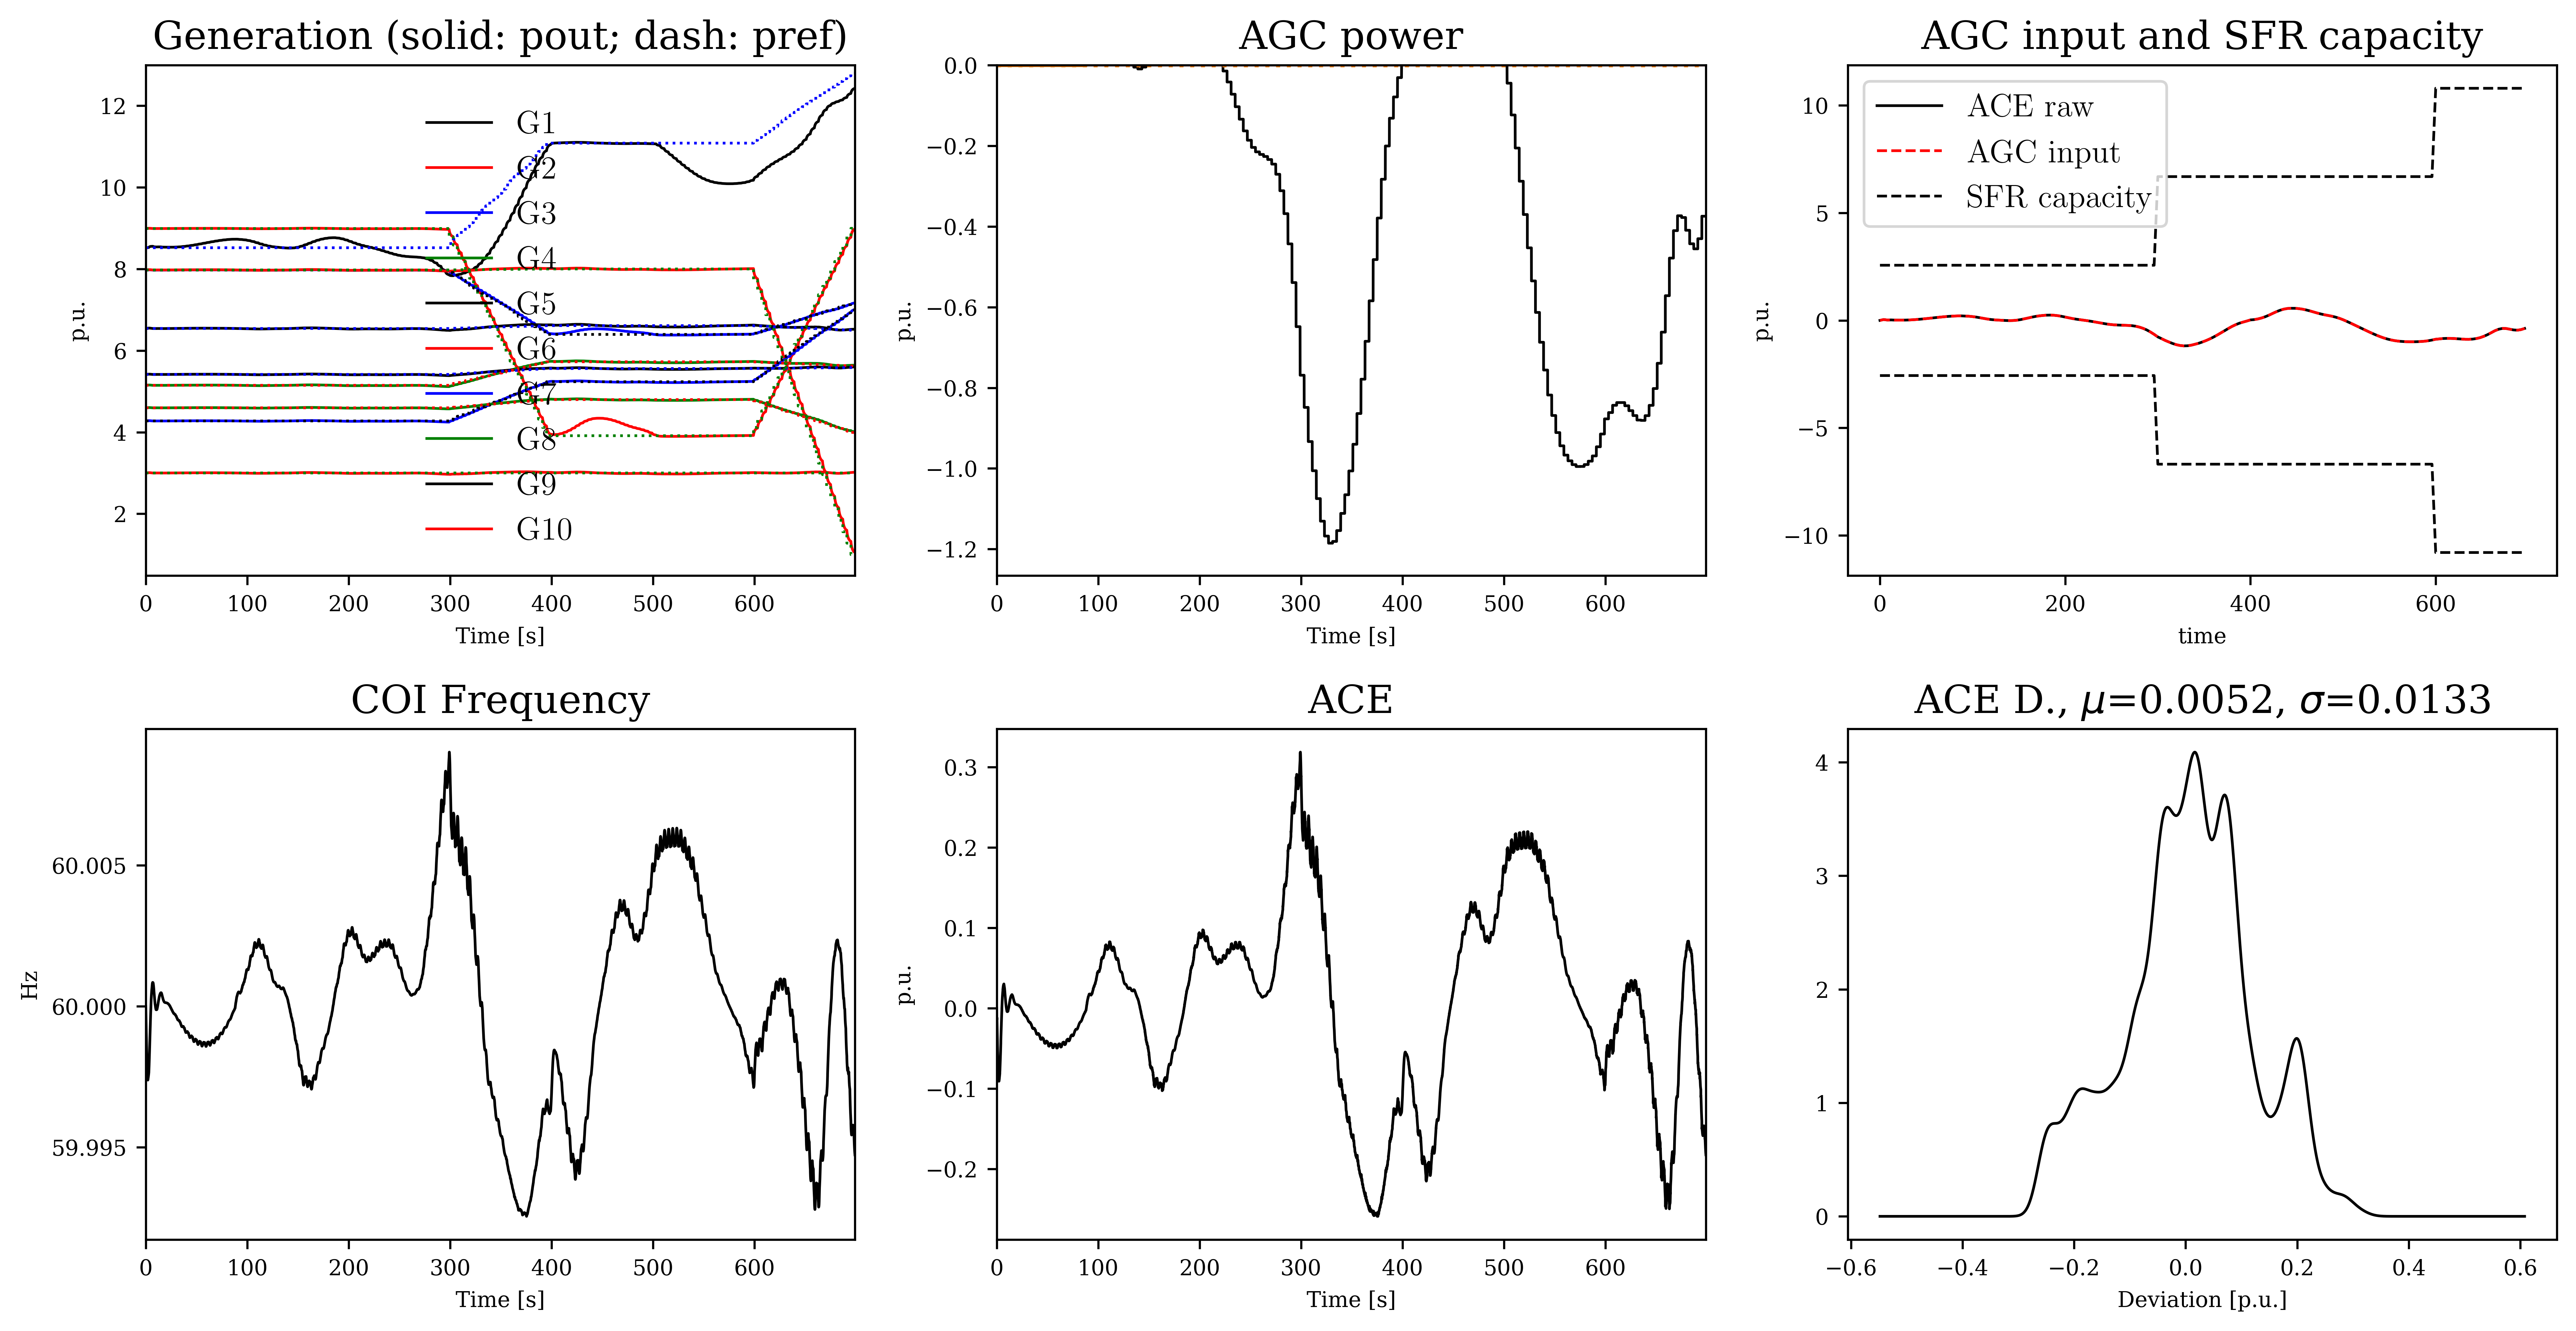

In [18]:
plt.style.use('ieee')

right = end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=False, show=False, right=right,
                 title=r'AGC power',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':')
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-')
ax_gen[0, 1].set_ylim(top=max(sse.Prl) * 1.2)

ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='ace',
             title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE D., $\mu$={ace_df.ace.mean().round(4)}, $\sigma$={ace_df.ace.var().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')